# The EM Algorithm for Gaussian Mixtures

## Imports

I will use numpy for the matrix calculations, scikit-learn for KMeans (used later in the initialization functions) and matplotlib to show the graphs of the log likelihood.

In [1]:
import numpy as np

np.set_printoptions(precision=2)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from tqdm import tqdm

## Load Data

The `gmm_input_path` should point to the file containing the 2-D samples. The output should be a (1000, 2) ndarray.

In [2]:
gmm_input_path = "./GMM.in"

with open(gmm_input_path, "r") as f:
    lines = f.readlines()
    X = np.array([x.split() for x in lines]).astype(np.float32)
    
print(f"The input shape is {X.shape}")

The input shape is (1000, 2)


## Gaussian Mixture Model

Here I implemented the multivariate gauss distribution function and I tested that it works by plotting a mesh with mean \[1, 2\] and variance \[\[1, 1\], \[0.5, 1\]\].

In [3]:
def multivariate_gauss(X, mu_k, sig_k):
    d = X.shape[1]
    e = -1/2 * np.sum((X - mu_k) @ np.linalg.inv(sig_k) * (X - mu_k), axis=1)
    n = (2 * np.pi) ** (d/2) * np.linalg.det(sig_k) ** 0.5
    return 1 / n * np.exp(e)

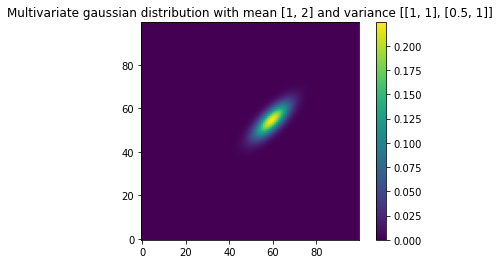

In [33]:
xs = np.array([[x, y] for x in np.linspace(-10, 10, 100) for y in np.linspace(-10, 10, 100)])
mu_k = np.array([1, 2])
sig_k = np.array([[1, 1], [0.5, 1]])

ys = multivariate_gauss(xs, mu_k, sig_k)

fig, ax = plt.subplots(1, 1)

plt.imshow(ys.reshape(100, 100))
ax.invert_yaxis()
plt.colorbar()
plt.title("Multivariate gaussian distribution with mean [1, 2] and variance [[1, 1], [0.5, 1]]")
plt.show()

In [4]:
def membership_weights(X, mu, sig, alpha):
    p_ks = np.array([multivariate_gauss(X, mu_k, sig_k) * alpha_k for mu_k, sig_k, alpha_k in zip(mu, sig, alpha)])
    p = np.sum(p_ks, axis=0)
    return np.array([p_k / p for p_k in p_ks]).T

## EM Algorithm

In [5]:
def e_step(X, mu, sig, alpha):
    return membership_weights(X, mu, sig, alpha)

In [6]:
def m_step(X, w):
    N = X.shape[0]
    
    N_ks = np.sum(w, axis=0)
    alpha_ks = N_ks / N
    
    mu_ks = ((X.T @ w) / N_ks).T
    
    K = w.shape[1]
    sig_ks = (1 / N_ks * np.array([np.sum(w[:, k] * (np.expand_dims((X - mu_ks[k]), axis=2) @ np.expand_dims((X - mu_ks[k]), axis=1)).T, axis=2) for k in range(K)]).T).T
        
    return mu_ks, sig_ks, alpha_ks

In [7]:
def log_likelihood(x, mu, sig, alpha):
    p_ks = np.array([multivariate_gauss(x, mu_k, sig_k) * alpha_k for mu_k, sig_k, alpha_k in zip(mu, sig, alpha)])
    return np.sum(np.log(np.sum(p_ks, axis=0)))

def run_converge(X, theta, iter=100):
    mu_ks, sig_ks, alpha_ks = theta
    loop = tqdm(range(iter))
    
    lls = [] 
    last_ll = log_likelihood(X, mu_ks, sig_ks, alpha_ks)
    for _ in loop:
        w = e_step(X, mu_ks, sig_ks, alpha_ks)
        mu_ks, sig_ks, alpha_ks = m_step(X, w)
        ll = log_likelihood(X, mu_ks, sig_ks, alpha_ks)
        
        loop.set_postfix(log_likelihood=ll)
        
        if np.abs(last_ll - ll) < 0.01:
            break
        
        last_ll = ll
        lls.append(ll)

    return (mu_ks, sig_ks, alpha_ks), lls

## Initialization Functions

In [8]:
def rand_init_theta(X, K=4):
    number_of_rows = X.shape[0]
    random_indices = np.random.choice(number_of_rows, size=K, replace=False)
    
    mu_ks = X[random_indices, :]
    sig_ks = np.array([np.cov(X.T) for _ in range(K)])
    alpha_ks = np.array([1 / K for _ in range(K)])
    
    return mu_ks, sig_ks, alpha_ks

def knn_init_theta(X, K=4):
    clf = KMeans(n_clusters=K)
    w = clf.fit_transform(X)
    
    return m_step(X, w)

def print_theta(theta):
    mu_ks, sig_ks, alpha_ks = theta
    for k, (mu_k, sig_k) in enumerate(zip(mu_ks, sig_ks)):
        print(f"mu_{k}:\n {mu_k}")
        print(f"sig_{k}:\n {sig_k}")
    print(f"alpha:\n {alpha_ks}")
    print()

## Random Initialization

The initial mean value for each GMM will be one of the points from the dataset, chosen randomly.

The initial variance matrix will be the same for every GMM and will be equal to the covariance matrix of the dataset.

The initial alpha parameter will contain the same probability for each model, being equal to 1/K.

  6%| | 55/1000 [00:00<00:02, 331.22it/s, log


mu_0:
 [-0.1  -0.07]
sig_0:
 [[0.88 0.11]
 [0.11 1.13]]
mu_1:
 [-2.86  6.93]
sig_1:
 [[ 2.68 -2.44]
 [-2.44  4.85]]
mu_2:
 [ 4.93 -0.03]
sig_2:
 [[1.83 0.86]
 [0.86 1.89]]
mu_3:
 [-2.1  -5.13]
sig_3:
 [[ 3.69 -1.11]
 [-1.11  4.05]]
alpha:
 [0.16 0.24 0.1  0.49]



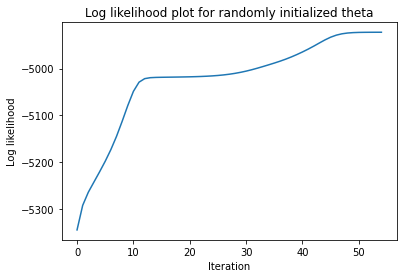

In [9]:
theta = rand_init_theta(X, K=4)
theta, lls = run_converge(X, theta, iter=1000)

print_theta(theta)

sns.lineplot(x=range(len(lls)), y=lls)
plt.title("Log likelihood plot for randomly initialized theta")
plt.ylabel("Log likelihood")
plt.xlabel("Iteration")
plt.show()

## KMeans Initialization

In the case of KMeans initialization I will compute the membership weights as the distances for each point from the obtained centroids. Then I will use the m step to compute each of the theta parameters.

  5%| | 52/1000 [00:00<00:02, 471.42it/s, log


mu_0:
 [-2.1  -5.13]
sig_0:
 [[ 3.69 -1.11]
 [-1.11  4.05]]
mu_1:
 [ 4.93 -0.03]
sig_1:
 [[1.84 0.87]
 [0.87 1.9 ]]
mu_2:
 [-0.1  -0.06]
sig_2:
 [[0.87 0.1 ]
 [0.1  1.13]]
mu_3:
 [-2.86  6.93]
sig_3:
 [[ 2.68 -2.44]
 [-2.44  4.84]]
alpha:
 [0.49 0.1  0.16 0.24]



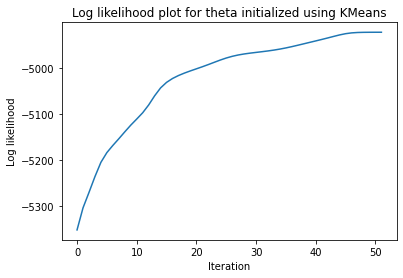

In [10]:
theta = knn_init_theta(X, K=4)
theta, lls = run_converge(X, theta, iter=1000)

print_theta(theta)
sns.lineplot(x=range(len(lls)), y=lls)
plt.title("Log likelihood plot for theta initialized using KMeans")
plt.ylabel("Log likelihood")
plt.xlabel("Iteration")
plt.show()